#### Case a ser respondindo
1) Considere que você é o cientista de dados responsável pela análise do comportamento e evolução do balanço final da empresa mês a mês, para tal, foi disponibilizado um arquivo (metricas_financeiras_mensais) com duas colunas, uma com a data de apuração do balanço financeiro e outra com o valor em reais do balanço no mês de referência. Sendo assim, foram solicitadas as seguintes informações para a tomada de decisões futuras:

- a) Quais os 5 meses com o melhor fechamento de balanço e quais os 5 meses com o pior fechamento de balanço?

- b) Qual foi o melhor ano para a empresa em termos de ganho total? Qual a média de fechamento de balanço ano a ano? A média e a mediana se aproximam? Em caso de negativa, explique o motivo.

- c) Qual o maior período de meses com o maior somatório de balanço ininterrupto? Em que mês se inicia e finaliza esse período e qual o valor total do mesmo? Como base para responder essas questões, considere o seguinte exemplo:
lista_exemplo=[1,1,2,4,-5,20,-100,22]
A faixa de maior soma se dá entre o primeiro e o sexto termo da lista, visto
que, 1+1+2+4-5+20=23.

- d) Se fosse solicitado para que você estimasse o balanço final dos meses de outubro, novembro e dezembro de 2024 considerando o comportamento observado nos meses anteriores, qual seria a sua estratégia para abordar o problema?


# 1. BIBLIOTECAS

In [168]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller # importar o teste ADF
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import pmdarima as pm
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot


# 2. Funções

In [150]:
def kadane(arr):
    max_sum = float('-inf')  # Inicializa com o menor valor possível
    current_sum = 0
    start = 0
    end = 0
    temp_start = 0

    for i in range(len(arr)):
        current_sum += arr[i]

        # Se o valor atual é maior que a soma acumulada, começa uma nova subsequência
        if current_sum > max_sum:
            max_sum = current_sum
            start = temp_start
            end = i

        # Se a soma atual for negativa, reinicia a soma
        if current_sum < 0:
            current_sum = 0
            temp_start = i + 1

    return max_sum, start, end

# 3. IMPORTANDO ARQUIVOS CSV

In [151]:

df_metricas_mensais = pd.read_csv(r'C:\Users\user\Desktop\Estudos_Data_Science\Case_tecnico_CDJ\metricas_financeiras_mensais.csv')
# transformar coluna Data para tipo datetime

df_metricas_mensais['Data'] = pd.to_datetime(df_metricas_mensais['Data'], format=('%Y-%m') )

# 4. Perguntas do teste tecnico:

### a) Quais os 5 meses com o melhor fechamento de balanço e quais os 5 meses com o pior fechamento de balanço?

In [152]:
# 5 meses com o melhor fechamento e pior fechamnto:
df_ordenado = df_metricas_mensais.sort_values(by='Balanço Final', ascending=False)

print(df_ordenado.head(5))
print(df_ordenado.tail(5))

          Data  Balanço Final
63  2015-04-01      268988.61
13  2011-02-01      263324.75
25  2012-02-01      209121.28
114 2019-07-01      199522.44
126 2020-07-01      186999.54
          Data  Balanço Final
150 2022-07-01     -221165.42
119 2019-12-01     -223749.25
69  2015-10-01     -225372.41
111 2019-04-01     -244345.22
135 2021-04-01     -245650.86


Fato:
Dados abaixo de 2020, tiveram um balanço melhor do que os dados mais recentes,2021,2022

In [153]:
# Ordenar df pelos 5 melhores e 5 piores fechamentos de balanço
df_ordenado = df_metricas_mensais.sort_values(by='Balanço Final', ascending=False)

# Separar os 5 melhores e 5 piores fechamentos
melhores_fechamentos = df_ordenado.head(5)
piores_fechamentos = df_ordenado.tail(5)

# Configurar o estilo e a paleta
sns.set_palette('Accent')
sns.set_style('darkgrid')



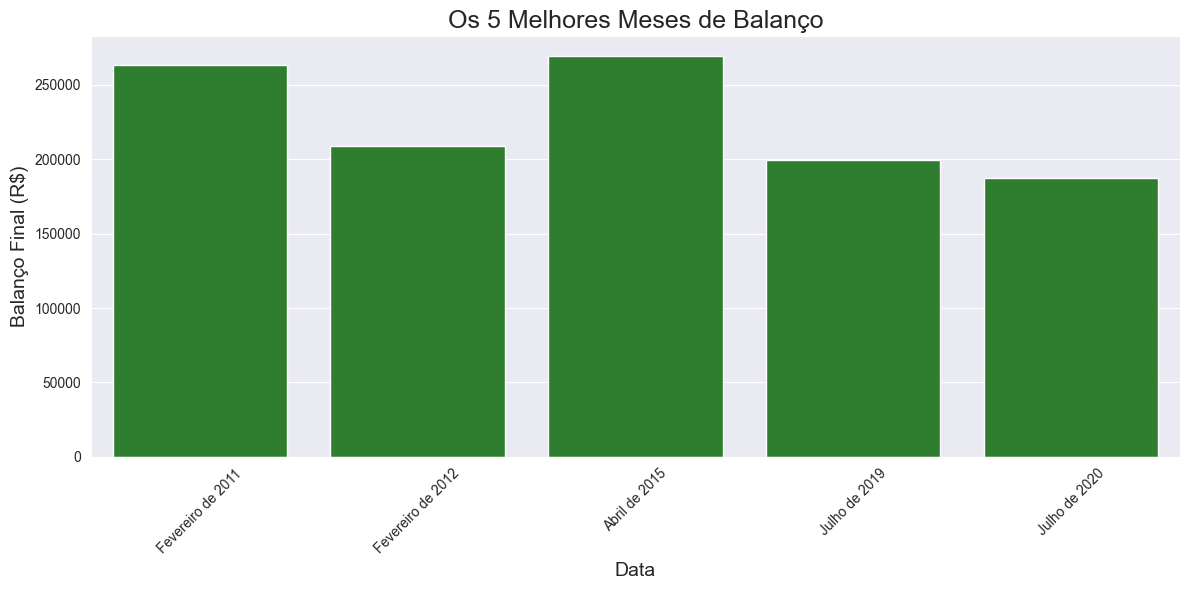

In [154]:

# Ordenar df pelos 5 melhores fechamentos de balanço
melhores_fechamentos = df_metricas_mensais.sort_values(by='Balanço Final', ascending=False).head(5)

# Ajustar a coluna 'Data' para o formato "Mês de Ano" 
melhores_fechamentos['Data'] = pd.to_datetime(melhores_fechamentos['Data'])
melhores_fechamentos['Data'] = melhores_fechamentos['Data'].dt.strftime('%B de %Y')

# Reordenar os meses 
melhores_fechamentos['Data'] = pd.to_datetime(melhores_fechamentos['Data'], format='%B de %Y')
melhores_fechamentos = melhores_fechamentos.sort_values(by='Data')

meses_pt = {
    'January': 'Janeiro', 'February': 'Fevereiro', 'March': 'Março',
    'April': 'Abril', 'May': 'Maio', 'June': 'Junho',
    'July': 'Julho', 'August': 'Agosto', 'September': 'Setembro',
    'October': 'Outubro', 'November': 'Novembro', 'December': 'Dezembro'
}


melhores_fechamentos['Data'] = melhores_fechamentos['Data'].dt.month_name().replace(meses_pt) + ' de ' + melhores_fechamentos['Data'].dt.year.astype(str)

#grafico
plt.figure(figsize=(12, 6))
sns.barplot(x='Data', y='Balanço Final', data=melhores_fechamentos, color='forestgreen')
plt.title('Os 5 Melhores Meses de Balanço', fontsize=18)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Balanço Final (R$)', fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


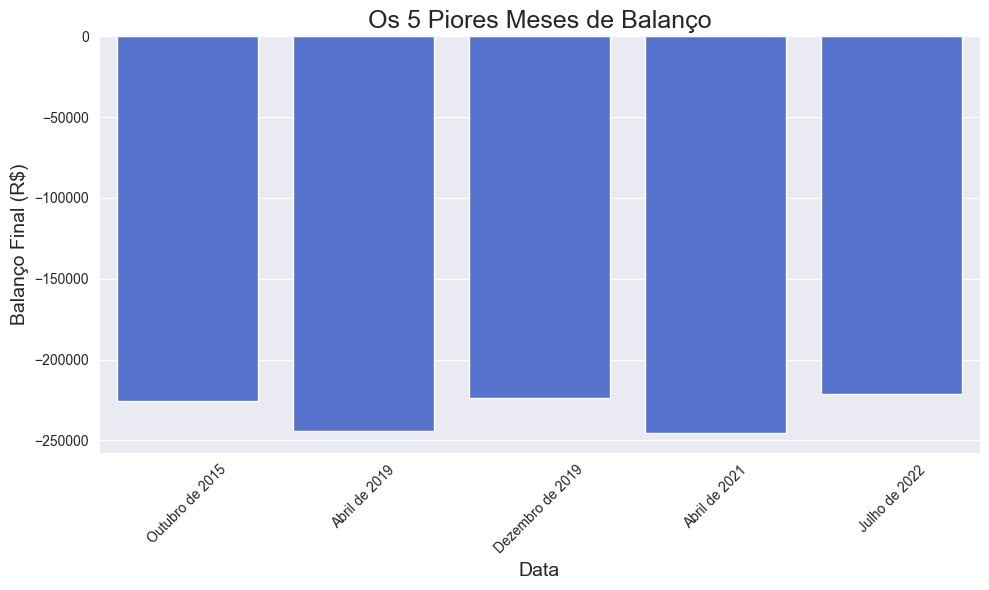

In [155]:
piores_fechamentos = df_metricas_mensais.sort_values(by='Balanço Final', ascending=True).head(5)

# Ajustar a coluna 'Data' para o formato "Mês de Ano"
piores_fechamentos['Data'] = pd.to_datetime(piores_fechamentos['Data'])
piores_fechamentos['Data'] = piores_fechamentos['Data'].dt.strftime('%B de %Y')
piores_fechamentos['Data'] = pd.to_datetime(piores_fechamentos['Data'], format='%B de %Y')
piores_fechamentos = piores_fechamentos.sort_values(by='Data')

meses_pt = {
    'January': 'Janeiro', 'February': 'Fevereiro', 'March': 'Março',
    'April': 'Abril', 'May': 'Maio', 'June': 'Junho',
    'July': 'Julho', 'August': 'Agosto', 'September': 'Setembro',
    'October': 'Outubro', 'November': 'Novembro', 'December': 'Dezembro'
}
piores_fechamentos['Data'] = piores_fechamentos['Data'].dt.month_name().replace(meses_pt) + ' de ' + piores_fechamentos['Data'].dt.year.astype(str)

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Data', y='Balanço Final', data=piores_fechamentos, color='#4169E1')
plt.title('Os 5 Piores Meses de Balanço', fontsize=18)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Balanço Final (R$)', fontsize=14)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


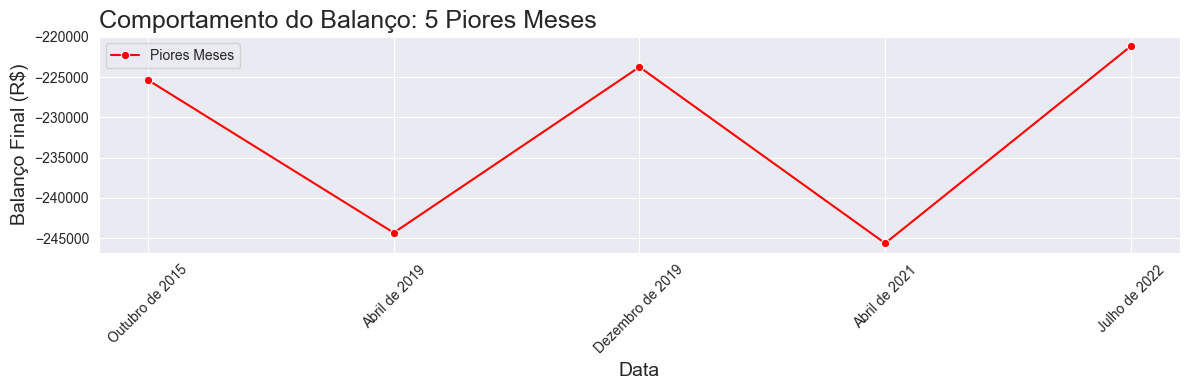

In [156]:
#Gráfico para os 5 piores meses

sns.set_palette('Accent')
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4))
ax = sns.lineplot(x="Data", y="Balanço Final", marker='o', 
                  data=piores_fechamentos, label='Piores Meses', color='red')

# Adicionar título e rótulos
ax.set_title('Comportamento do Balanço: 5 Piores Meses', loc='left', fontsize=18)
ax.set_xlabel('Data', fontsize=14)
ax.set_ylabel('Balanço Final (R$)', fontsize=14)


plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


###  b) Qual foi o melhor ano para a empresa em termos de ganho total? Qual a média de fechamento de balanço ano a ano? A média e a mediana se aproximam? Em caso de negativa, explique o motivo.

In [157]:
df_metricas_mensais['Ano_Balanco'] = df_metricas_mensais['Data'].dt.year
df_metricas_mensais

,Data,Balanço Final,Ano_Balanco
0,2010-01-01,32411.56,2010
1,2010-02-01,-62423.96,2010
2,2010-03-01,135070.95,2010
3,2010-04-01,-94712.30,2010
4,2010-05-01,4944.98,2010
...,...,...,...
172,2024-05-01,162121.17,2024
173,2024-06-01,-91480.87,2024
174,2024-07-01,633.56,2024
175,2024-08-01,-158496.18,2024


In [158]:
ganho_total_ano =  df_metricas_mensais.groupby('Ano_Balanco')['Balanço Final'].sum().reset_index()

In [159]:
melhor_ano = ganho_total_ano.loc[ganho_total_ano['Balanço Final'].idxmax()]
melhor_ano

Ano_Balanco        2020.00
Balanço Final    405696.86
Name: 10, dtype: float64

O melhor ano foi em 2020, com um balanço final de 405696.86

In [160]:
#verificar a média por ano a ano

media_por_ano = df_metricas_mensais.groupby('Ano_Balanco')['Balanço Final'].mean().reset_index()
media_por_ano

,Ano_Balanco,Balanço Final
0,2010,-1741.830000
1,2011,-16297.294167
2,2012,23490.956667
3,2013,-29652.595833
4,2014,29912.709167
5,2015,14302.085833
6,2016,-34708.010833
7,2017,16571.443333
8,2018,-12542.254167
9,2019,-23100.625000


In [161]:
#MVerificar Mediana por ano a ano

mediana_por_ano = df_metricas_mensais.groupby('Ano_Balanco')['Balanço Final'].median().reset_index()
mediana_por_ano

,Ano_Balanco,Balanço Final
0,2010,-6642.165
1,2011,-40551.795
2,2012,1073.205
3,2013,-32070.200
4,2014,51555.935
5,2015,2128.575
6,2016,-34988.800
7,2017,15592.210
8,2018,1175.990
9,2019,-2327.590


In [162]:
media_e_mediana = media_por_ano.merge(mediana_por_ano, on='Ano_Balanco', suffixes=('_media', '_mediana'))

# Definir uma tolerância (5% da média)
tolerancia = 0.05  
# Calcular a diferença absoluta
media_e_mediana['diferenca'] = abs(media_e_mediana['Balanço Final_media'] - media_e_mediana['Balanço Final_mediana'])

# Verificar se a média e a mediana se aproximam dentro da tolerância
media_e_mediana['aproximam'] = media_e_mediana['diferenca'] <= (tolerancia * media_e_mediana['Balanço Final_media'])

# Motivos onde a média e a mediana não se aproximam
motivos = media_e_mediana[~media_e_mediana['aproximam']][['Ano_Balanco', 'Balanço Final_media', 'Balanço Final_mediana', 'diferenca']]
print("Motivos onde a média e a mediana não se aproximam:")
print(motivos)



Motivos onde a média e a mediana não se aproximam:
    Ano_Balanco  Balanço Final_media  Balanço Final_mediana     diferenca
0          2010         -1741.830000              -6642.165   4900.335000
1          2011        -16297.294167             -40551.795  24254.500833
2          2012         23490.956667               1073.205  22417.751667
3          2013        -29652.595833             -32070.200   2417.604167
4          2014         29912.709167              51555.935  21643.225833
5          2015         14302.085833               2128.575  12173.510833
6          2016        -34708.010833             -34988.800    280.789167
7          2017         16571.443333              15592.210    979.233333
8          2018        -12542.254167               1175.990  13718.244167
9          2019        -23100.625000              -2327.590  20773.035000
10         2020         33808.071667              41525.580   7717.508333
11         2021         -2032.526667             -18339.835  

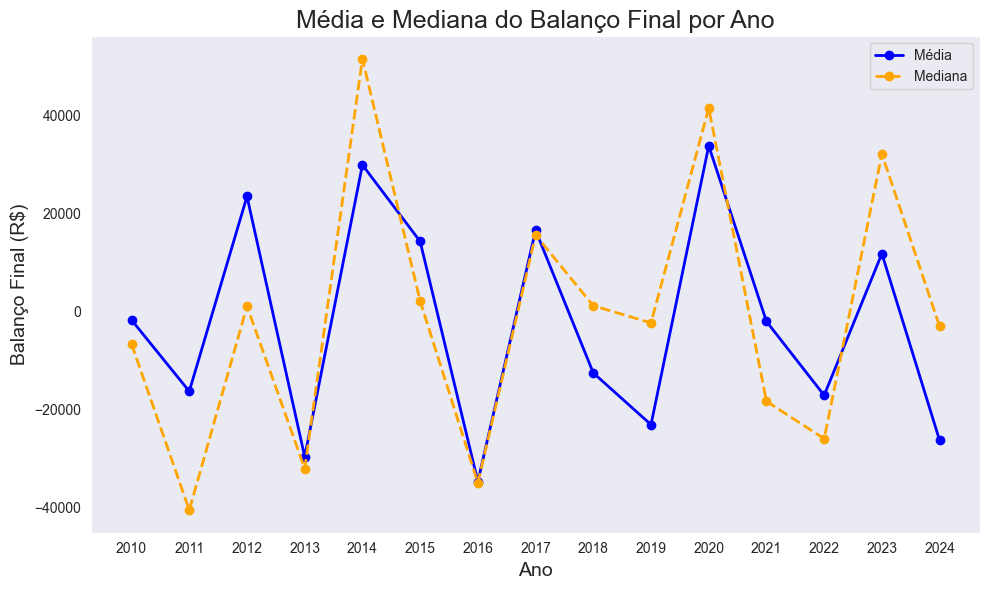

In [163]:
plt.figure(figsize=(10, 6))

# calcular média
plt.plot(media_e_mediana['Ano_Balanco'], media_e_mediana['Balanço Final_media'], 
         marker='o', label='Média', color='blue', linestyle='-', linewidth=2)

# calcular mediana
plt.plot(media_e_mediana['Ano_Balanco'], media_e_mediana['Balanço Final_mediana'], 
         marker='o', label='Mediana', color='orange', linestyle='--', linewidth=2)

plt.title('Média e Mediana do Balanço Final por Ano', fontsize=18)
plt.xlabel('Ano', fontsize=14)
plt.ylabel('Balanço Final (R$)', fontsize=14)
plt.xticks(media_e_mediana['Ano_Balanco'])  
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Com base nesses resultados, não podemos afirmar que a média e a mediana se aproximam. Na maioria dos anos, a diferença entre a média (Balanço Final_media) e a mediana (Balanço Final_mediana) é bastante significativa.

Análise detalhada:
Grandes diferenças: Em muitos casos, como 2010, 2011, 2012, 2019, 2023, e 2024, a diferença entre a média e a mediana é muito grande, indicando que os dados estão dispersos, com possíveis valores extremos ou uma distribuição assimétrica.
Pequenas diferenças: Em anos como 2013, 2016, e 2017, a diferença é menor, mas ainda não suficiente para dizer que a média e a mediana são praticamente iguais.
Resposta:
Não, a média e a mediana não se aproximam de forma consistente ao longo dos anos. Isso sugere que os dados apresentam grande variação ou são influenciados por valores extremos (outliers), o que faz com que a média seja mais impactada do que a mediana. Isso é típico em distribuições assimétricas ou quando há valores atípicos.

Em resumo, a diferença entre a média e a mediana sugere que os dados têm uma distribuição que afasta essas duas medidas centrais na maioria dos anos.




### c) Qual o maior período de meses com o maior somatório de balanço ininterrupto? Em que mês se inicia e finaliza esse período e qual o valor total do mesmo? Como base para responder essas questões, considere o seguinte exemplo:
lista_exemplo=[1,1,2,4,-5,20,-100,22]
A faixa de maior soma se dá entre o primeiro e o sexto termo da lista, visto
que, 1+1+2+4-5+20=23.


Para responder à pergunta sobre o maior período de meses com o maior somatório de balanço ininterrupto, podemos resolver utilizando o algoritmo de Kadane.

Passos:
- Utilizar o algoritmo de Kadane para encontrar a subsequência com a maior soma dentro de um período ininterrupto.
- Identificar os meses de início e fim do período.
- Calcular o valor total desse período.

In [164]:
# Extrai a coluna de "Balanço Final" como uma lista
balanco_list = df_metricas_mensais['Balanço Final'].tolist()

# Algoritmo de Kadane
max_sum, start_idx, end_idx = kadane(balanco_list)

In [165]:
# Pega o mês de início e fim da sequência com maior soma
mes_inicio = df_metricas_mensais.loc[start_idx, 'Data']
mes_fim = df_metricas_mensais.loc[end_idx, 'Data']

print(f"Maior período de meses com maior somatório de balanço ininterrupto vai de {mes_inicio} até {mes_fim}")
print(f"Valor total do balanço nesse período: {max_sum}")


Maior período de meses com maior somatório de balanço ininterrupto vai de 2014-02-01 00:00:00 até 2015-09-01 00:00:00
Valor total do balanço nesse período: 975952.3800000001


### d) Se fosse solicitado para que você estimasse o balanço final dos meses de
- outubro, 
- novembro e 
- dezembro de 2024 
considerando o comportamento observado nos meses anteriores, qual seria a sua estratégia para abordar o problema?

Abordagem 1 séries temporais usando ARIMA

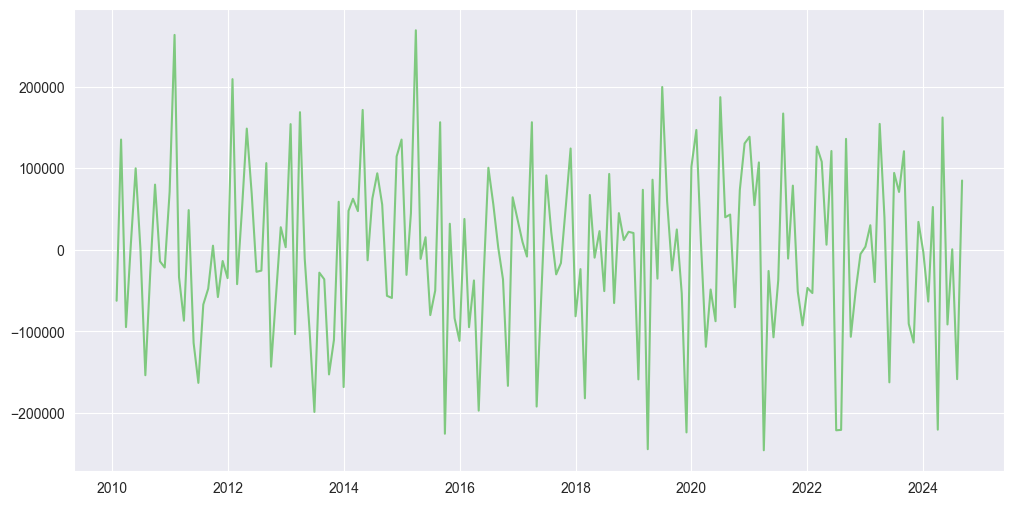

In [166]:
df_modelagem_metricas = df_metricas_mensais[['Data', 'Balanço Final']]
df_modelagem_metricas = df_modelagem_metricas.groupby('Data').agg({'Balanço Final':'sum'})
df_modelagem_metricas.reset_index(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_modelagem_metricas['Data'][1:], df_modelagem_metricas['Balanço Final'][1:])

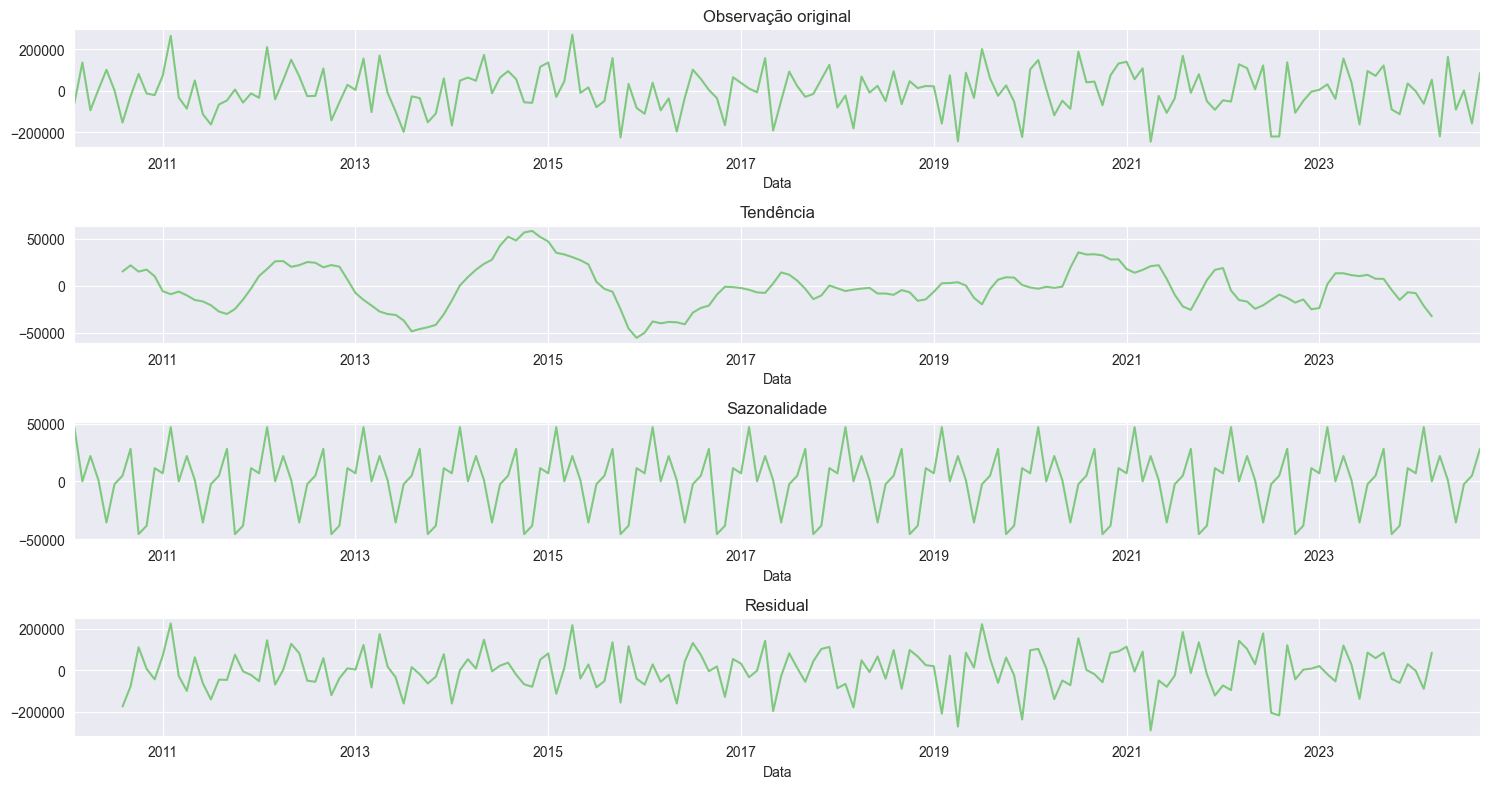

In [167]:
df_modelagem_metricas.set_index('Data', inplace=True)

result = seasonal_decompose(df_modelagem_metricas[1:])

#Plotar em tamanho maior
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
result.observed.plot(ax=ax1, title='Observação original')
result.trend.plot(ax=ax2, title='Tendência')
result.seasonal.plot(ax=ax3, title='Sazonalidade')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()

In [169]:
# Transformar a coluna 'Data' em índice se ainda não estiver
df_metricas_mensais['Data'] = pd.to_datetime(df_metricas_mensais['Data'])
df_metricas_mensais.set_index('Data', inplace=True)

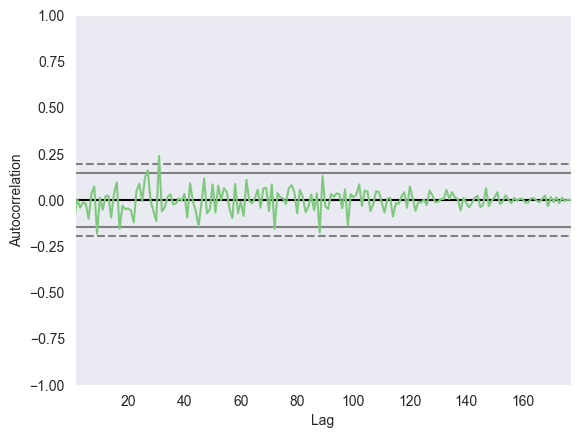

In [170]:

# autocorrelation plot 
autocorrelation_plot(df_metricas_mensais)
pyplot.show()

In [171]:
teste_diff = df_modelagem_metricas[1:]
#teste_diff['Soma de pedidos'] = teste_diff['Soma de pedidos'].diff()
X = teste_diff['Balanço Final'].values

# aplicar ADF 
result = adfuller(X)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result[0]))
print('Valor-p: {:.4f}'.format(result[1]))
print('Valores Críticos:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))


#valores teste esttística maior que os valores críticos sugerindo a série ser estacionária

Dickey-Fuller Aumentado
Teste Estatístico: -14.4752
Valor-p: 0.0000
Valores Críticos:
	1%: -3.4683
	5%: -2.8782
	10%: -2.5757


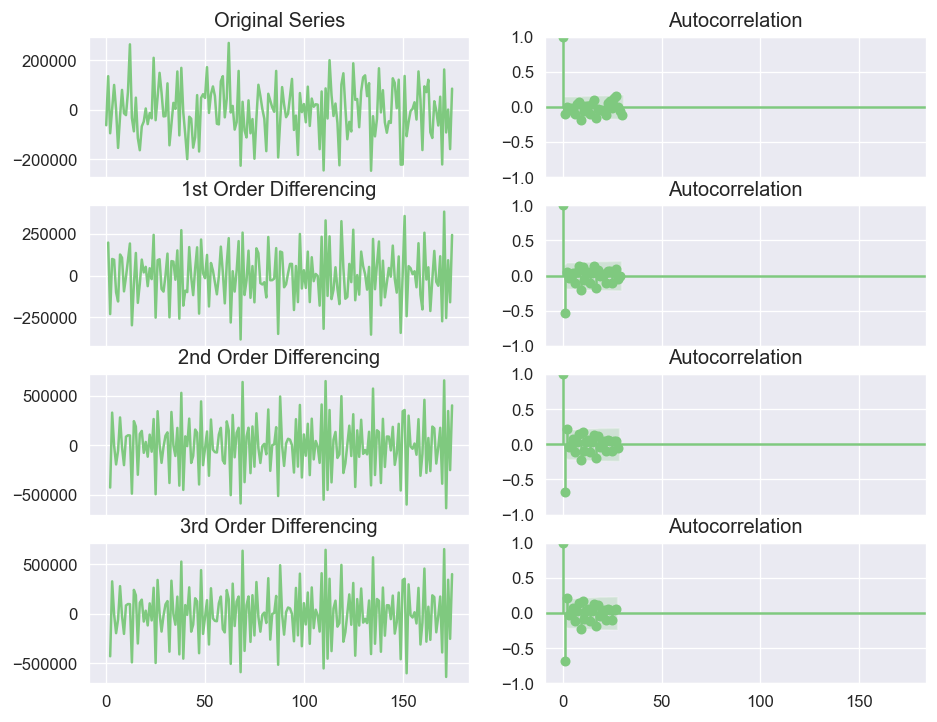

In [172]:
teste = df_modelagem_metricas[1:]

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

teste_plot = teste.reset_index()

# Série Original
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(teste_plot['Balanço Final']); axes[0, 0].set_title('Original Series')
plot_acf(teste_plot['Balanço Final'], ax=axes[0, 1], lags=30)

# 1st Diferenciação
axes[1, 0].plot(teste_plot['Balanço Final'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(teste_plot['Balanço Final'].diff().dropna(), ax=axes[1, 1], lags=29)

# 2nd Diferenciação
axes[2, 0].plot(teste_plot['Balanço Final'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(teste_plot['Balanço Final'].diff().diff().dropna(), ax=axes[2, 1], lags=28)

axes[3, 0].plot(teste_plot['Balanço Final'].diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(teste_plot['Balanço Final'].diff().diff().dropna(), ax=axes[3, 1], lags=27)

plt.show()

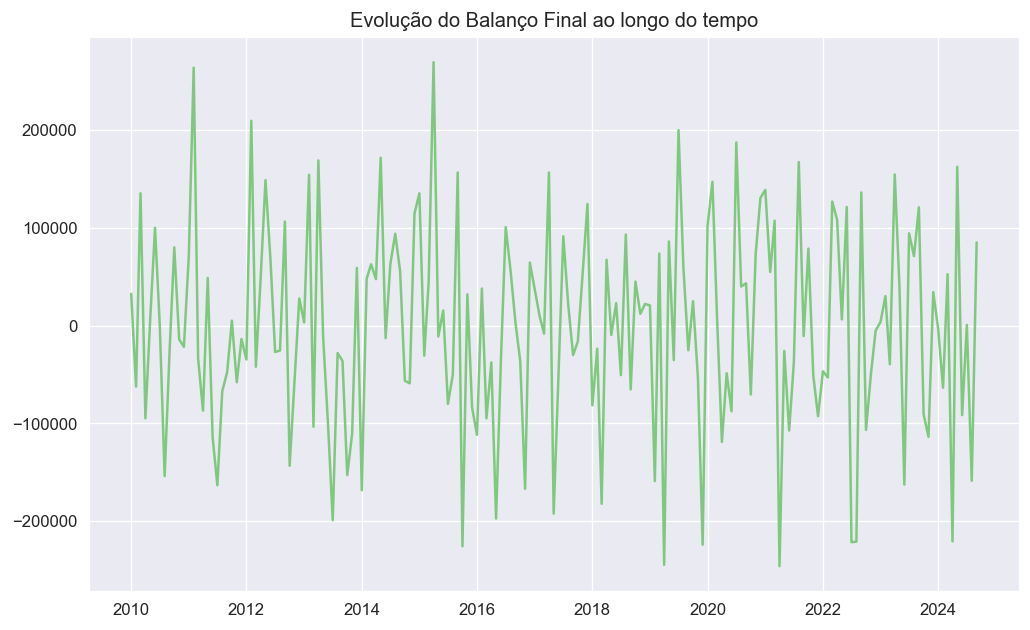

c:\Users\user\Desktop\Estudos_Data_Science\Case_tecnico_CDJ\teste_tecnico\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\user\Desktop\Estudos_Data_Science\Case_tecnico_CDJ\teste_tecnico\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\user\Desktop\Estudos_Data_Science\Case_tecnico_CDJ\teste_tecnico\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:          Balanço Final   No. Observations:                  177
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2290.131
Date:                Sat, 05 Oct 2024   AIC                           4588.262
Time:                        11:01:18   BIC                           4600.966
Sample:                    01-01-2010   HQIC                          4593.414
                         - 09-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1831.4102   1076.380     -1.701      0.089   -3941.077     278.256
ar.L1          0.8515      0.044     19.251      0.000       0.765       0.938
ma.L1         -0.9982      0.108     -9.275      0.0

C:\Users\user\AppData\Local\Temp\ipykernel_25112\4194268782.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=df_metricas_mensais.index[-1], periods=4, freq='M')[1:], previsoes, label='Previsão', linestyle='--', color='red')


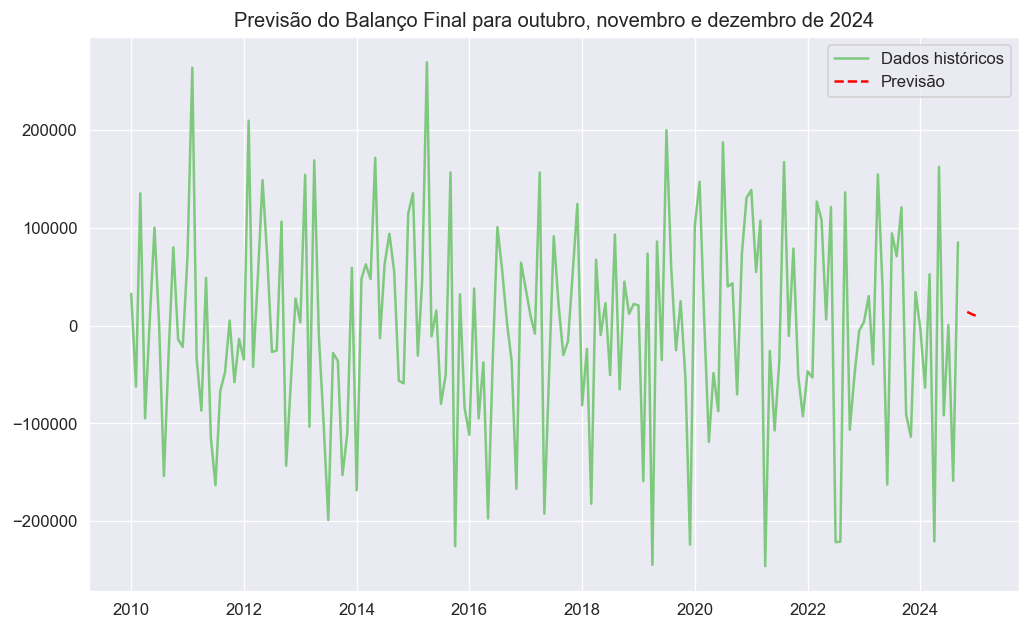

In [176]:
# Plotar a série temporal para visualizar o comportamento do Balanço Final ao longo do tempo
plt.figure(figsize=(10,6))
plt.plot(df_metricas_mensais['Balanço Final'], label='Balanço Final')
plt.title('Evolução do Balanço Final ao longo do tempo')
plt.show()

# Ajustar o modelo ARIMA
# Baseado no teste de ADF, não precisamos diferenciar, então o parâmetro d = 0
# Vamos começar com um ARIMA simples (p=1, d=0, q=1) e ajustar conforme necessário

# Definir os parâmetros do modelo ARIMA
p = 1  # Parte autoregressiva
d = 0  # Série já estacionária (não precisa de diferenciação)
q = 1  # Parte de média móvel

# Ajustar o modelo ARIMA aos dados
model = ARIMA(df_metricas_mensais['Balanço Final'], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# Fazer as previsões para os meses de outubro, novembro e dezembro de 2024
previsoes = model_fit.forecast(steps=3) 
print(f"Previsões para os próximos 3 meses (outubro, novembro e dezembro de 2024):\n{previsoes}")

plt.figure(figsize=(10,6))
plt.plot(df_metricas_mensais['Balanço Final'], label='Dados históricos')
plt.plot(pd.date_range(start=df_metricas_mensais.index[-1], periods=4, freq='M')[1:], previsoes, label='Previsão', linestyle='--', color='red')
plt.title('Previsão do Balanço Final para outubro, novembro e dezembro de 2024')
plt.legend()
plt.show()


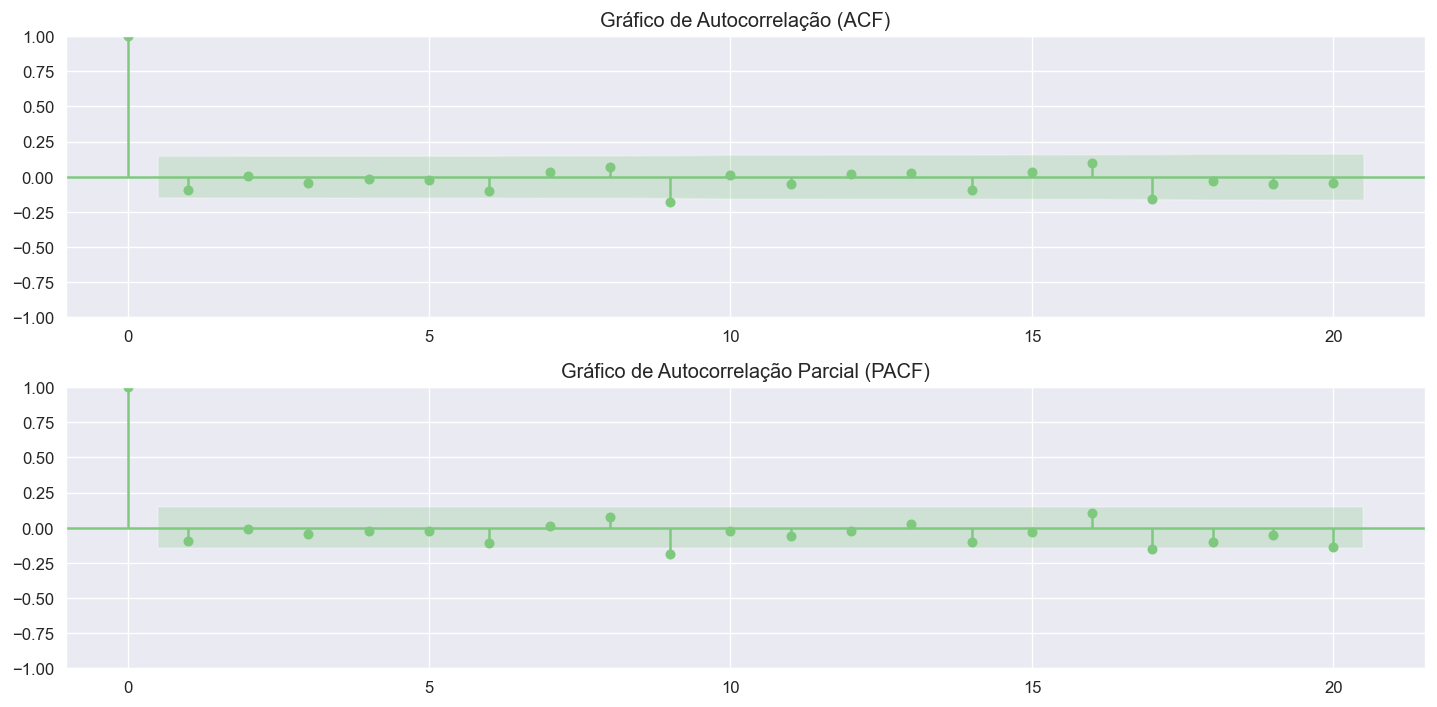

In [178]:
#grafico Acf e Pacf
serie_temporal = df_metricas_mensais['Balanço Final']

# Plotando o gráfico de autocorrelação (ACF)
plt.figure(figsize=(12, 6))

plt.subplot(211)
plot_acf(serie_temporal, lags=20, ax=plt.gca())
plt.title('Gráfico de Autocorrelação (ACF)')

# Plotando o gráfico de autocorrelação parcial (PACF)
plt.subplot(212)
plot_pacf(serie_temporal, lags=20, ax=plt.gca(), method='ywm')
plt.title('Gráfico de Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()


Interpretação dos Resultados
Lag 0:

Autocorrelação: 1
Interpretação: Isso é esperado, pois a autocorrelação em lag 0 sempre será 1. Isso significa que cada valor da série está perfeitamente correlacionado consigo mesmo. Não é uma informação útil para a análise.
Lags 1 a 20:

Autocorrelações: Todos os valores em torno de 0
Interpretação:
Isso sugere que não há correlação significativa entre os valores da série em diferentes períodos. Ou seja, o valor atual da série não está relacionado com os valores anteriores em qualquer um dos lags de 1 a 20.
A ausência de correlação indica que a série temporal é não autocorrelacionada em relação a esses lags, o que significa que cada observação é, em média, independente das outras.
Explicação Didática
Aqui está uma maneira didática de explicar o que você observou:

O que observamos: Ao analisar os gráficos de ACF e PACF, notamos que, enquanto a autocorrelação no lag 0 é igual a 1 (como esperado), para os lags de 1 a 20, todos os valores estão em torno de 0.

Significado disso:

A autocorrelação em lag 0 é uma referência natural, pois ela simplesmente diz que um valor é perfeitamente correlacionado consigo mesmo. Contudo, quando olhamos para os lags de 1 a 20, os valores próximos de 0 indicam que não existe uma relação significativa entre um valor e seus antecessores imediatos.
Implicações:

Isso sugere que os valores da sua série temporal não dependem dos valores anteriores, o que é uma característica desejável em muitos modelos de previsão.
Essa independência pode indicar que a série é estacionária, ou seja, não possui tendências ou padrões sazonais que mudam ao longo do tempo. Portanto, a série não precisa de diferenciação para se tornar estacionária.
Conclusão
Com essas observações, você pode concluir que a série temporal que você está analisando é bastante "clean" no sentido de não ter autocorrelações significativas nos lags analisados. Isso é positivo, pois facilita a modelagem preditiva. Para aplicar um modelo ARIMA, você poderia considerar um modelo simples, possivelmente ARIMA(0, d, 0) ou mesmo um modelo de média, dependendo do que você pretende prever.

In [190]:
df_metricas_mensais = pd.read_csv(r'C:\Users\user\Desktop\Estudos_Data_Science\Case_tecnico_CDJ\metricas_financeiras_mensais.csv')
# transformar coluna Data para tipo datetime

df_metricas_mensais['Data'] = pd.to_datetime(df_metricas_mensais['Data'], format=('%Y-%m') )

In [187]:
df_metricas_mensais['Balanço Final'].tail()

172    162121.17
173    -91480.87
174       633.56
175   -158496.18
176     84892.74
Name: Balanço Final, dtype: float64

c:\Users\user\Desktop\Estudos_Data_Science\Case_tecnico_CDJ\teste_tecnico\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\user\Desktop\Estudos_Data_Science\Case_tecnico_CDJ\teste_tecnico\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\user\Desktop\Estudos_Data_Science\Case_tecnico_CDJ\teste_tecnico\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Previsões para junho, julho e agosto de 2024:
2024-06-01    4302.688313
2024-07-01    3502.595630
2024-08-01    2824.978151
Freq: MS, Name: predicted_mean, dtype: float64
Valores reais para junho, julho e agosto de 2024:
Data
2024-06-01    -91480.87
2024-07-01       633.56
2024-08-01   -158496.18
Name: Balanço Final, dtype: float64
Erro Absoluto Médio (MAE): 86657.91736480029
Erro Quadrático Médio (MSE): 11735745825.26867
Raiz do Erro Quadrático Médio (RMSE): 108331.64738555705


C:\Users\user\AppData\Local\Temp\ipykernel_25112\2106289672.py:41: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=train_data.index[-1], periods=4, freq='M')[1:], previsoes, label='Previsão', linestyle='--', color='red')


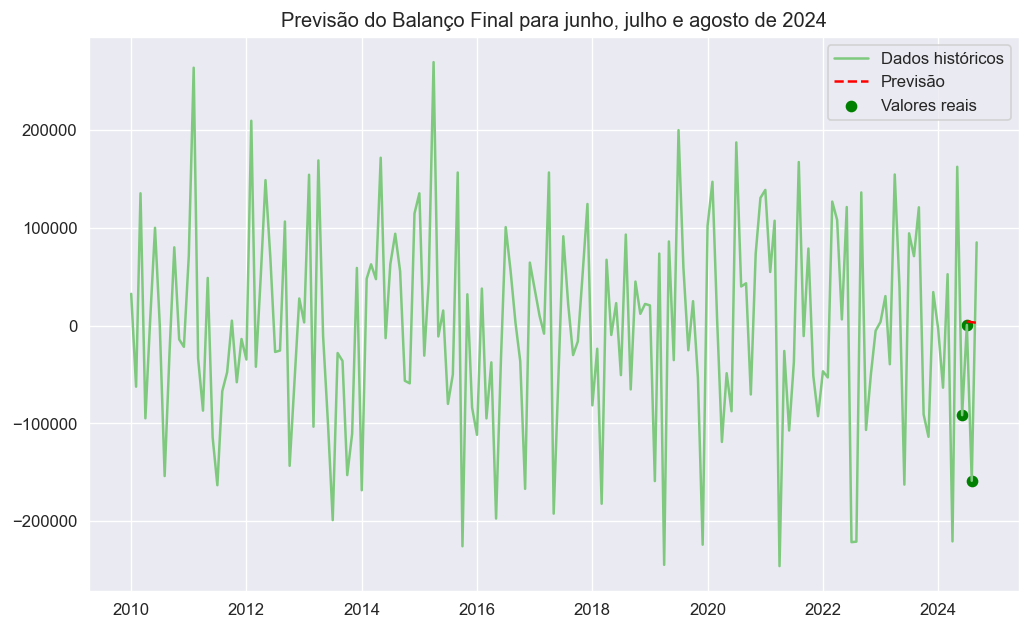

In [192]:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Verificar se a coluna 'Data' está no formato datetime
if not pd.api.types.is_datetime64_any_dtype(df_metricas_mensais.index):
    df_metricas_mensais['Data'] = pd.to_datetime(df_metricas_mensais['Data'])
    df_metricas_mensais.set_index('Data', inplace=True)

# Divisão dos dados em treino e teste
train_data = df_metricas_mensais[df_metricas_mensais.index < '2024-06-01']  # Comparação com datetime
test_data = df_metricas_mensais[df_metricas_mensais.index >= '2024-06-01']

# Ajustar o modelo ARIMA na parte de treino
p = 1  # Parte autoregressiva
d = 0  # Série já estacionária (não precisa de diferenciação)
q = 1  # Parte de média móvel

model = ARIMA(train_data['Balanço Final'], order=(p, d, q))
model_fit = model.fit()

# Fazer as previsões para os meses de junho, julho e agosto de 2024 (3 passos à frente)
previsoes = model_fit.forecast(steps=3)

# Comparar as previsões com os valores reais
valores_reais = test_data['Balanço Final'][:3]
print(f"Previsões para junho, julho e agosto de 2024:\n{previsoes}")
print(f"Valores reais para junho, julho e agosto de 2024:\n{valores_reais}")

# Calcular o erro das previsões
mae = mean_absolute_error(valores_reais, previsoes)
mse = mean_squared_error(valores_reais, previsoes)
rmse = np.sqrt(mse)

print(f"Erro Absoluto Médio (MAE): {mae}")
print(f"Erro Quadrático Médio (MSE): {mse}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse}")

# Visualizar as previsões e os dados reais
plt.figure(figsize=(10, 6))
plt.plot(df_metricas_mensais['Balanço Final'], label='Dados históricos')
plt.plot(pd.date_range(start=train_data.index[-1], periods=4, freq='M')[1:], previsoes, label='Previsão', linestyle='--', color='red')
plt.scatter(test_data.index[:3], valores_reais, label='Valores reais', color='green')
plt.title('Previsão do Balanço Final para junho, julho e agosto de 2024')
plt.legend()
plt.show()
